In [62]:
import pandas as pd
from datetime import timedelta
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder

In [63]:
df = pd.read_csv('/Users/oussamanaji/Downloads/dolead_vw_extract.csv')
df['starttimestamp'] = pd.to_datetime(df['starttimestamp'])
df['endtimestamp'] = pd.to_datetime(df['endtimestamp'])
df.loc[df['agent'] == 'vw', 'local_hour'] = df['starttimestamp'] + timedelta(hours=2)
df['local_hour'] = df['local_hour'].dt.hour

In [82]:
df.head()

,discussionid,agent,starttimestamp,endtimestamp,callto,duration,picked,zip_code,local_hour
0,CA2ea0921b2e50aa3c05729cac332e7630,dolead_att,2024-10-15 15:04:24.223,2024-10-15 15:04:28.909,18033371229,4.686,False,29130,NaN
1,CA175ce2872ee3ede611ef4859f70d495a,dolead_att,2024-10-15 15:10:14.815,2024-10-15 15:10:18.945,18033371229,4.130,False,29130,NaN
2,CA6e9749bbe599976e1144f0619c6f004a,dolead_att,2024-10-15 15:41:17.902,2024-10-15 15:41:22.887,15807401618,4.985,False,74701,NaN
3,CA510c4a5dd159f9b41eac700f6300a392,dolead_att,2024-10-15 15:46:39.239,2024-10-15 15:46:42.920,15807401618,3.681,False,74701,NaN
4,CAb258ea9d164dde4cf1cbaece5b32bae7,dolead_att,2024-10-15 15:51:53.959,2024-10-15 15:52:53.267,12294742370,59.308,True,31601,NaN


## Dolead

In [ ]:
# Initialiser les objets
search = SearchEngine(simple_zipcode=True)
tf = TimezoneFinder()

def get_timezone(zip_code):
    zipcode = search.by_zipcode(zip_code)
    if zipcode.lat and zipcode.lng:
        return tf.timezone_at(lat=zipcode.lat, lng=zipcode.lng)
    return None

df['zip_code'].apply(get_timezone)

In [83]:
df_dolead = df[df['agent'] == 'dolead_att'].copy()
# 1. Taux de décrochage au premier appel
# Garder le premier appel pour chaque numéro
premiers_appels = df_dolead.drop_duplicates(subset='callto', keep='first')
taux_decrochage_premier_appel = premiers_appels['picked'].mean()

# 2. Taux de décrochage après un échec du premier appel
# Récupérer les numéros où le premier appel a échoué
numeros_echoues = premiers_appels[premiers_appels['picked'] == False]['callto'].unique()

# Filtrer le DataFrame original pour ces numéros
appels_echoues = df_dolead[df_dolead['callto'].isin(numeros_echoues)]

# Garder le dernier appel pour chaque numéro
derniers_appels = appels_echoues.drop_duplicates(subset='callto', keep='last')

# Calculer le taux de décrochage dans ce sous-ensemble
taux_decrochage_apres_echec = derniers_appels['picked'].mean()

# Afficher les résultats
print(f"Taux de décrochage au premier appel : {taux_decrochage_premier_appel:.2%}")
print(f"Taux de décrochage après échec du premier appel : {taux_decrochage_apres_echec:.2%}")

Taux de décrochage au premier appel : 32.67%
Taux de décrochage après échec du premier appel : 23.76%


## VW 

In [77]:
df_vw = df[df['agent']=='vw'].copy()

In [57]:
df_vw['zip_code'].unique()

array([13013, 38000, 95800, 73000, 69140, 60000, 49000, 38100, 67000,
       52310, 33700, 94500, 93150, 78000, 92100, 78140, 44980, 11000,
       45680, 95190, 44230, 90000, 13003, 69800, 75018, 77000, 31200,
        5000, 94220, 94200, 78370, 26200, 76500, 61300, 94310, 92220,
       77164, 91700,  6000, 93300, 93100, 18390, 56100, 62820, 91000,
        6220, 59350, 27000, 79000, 14000, 76800, 54111, 42800, 76530,
       59400, 83000, 91940, 93270, 59760, 35000, 74240,  2600, 69300,
       59200, 85580, 82000, 91650, 92420, 27340, 57840, 75000, 70230,
       92150, 50340, 88190, 45000, 95100, 77410, 45800, 61130, 69008,
       80000, 69740, 59100, 78360, 83400, 95400, 69009,  1000, 84200,
        1700, 68000, 75013, 74100, 62117, 44000,   480, 67800, 76000,
       91230, 94450, 95230, 38200, 57000, 91550, 93420, 25230, 13270,
       83200, 31000, 59223, 50700, 35740, 72300, 76480, 34000,  2100,
       92400, 58200, 13200, 33270, 74520, 40360,  1940, 91310, 60200,
       40100, 13140,

In [78]:
def categorize_region(zip_code):
    zip_code_str = str(zip_code)
    if zip_code_str.startswith(('75', '77', '78', '91', '92', '93', '94', '95')):
        return 'Région Parisienne'
    elif zip_code_str.startswith(('69', '13', '31', '33', '59', '67', '44')):  # Grandes villes
        return 'Province Grandes Villes'
    else:
        return 'Province Petites Villes'

# Appliquer la fonction pour créer la colonne 'region'
df_vw['region'] = df_vw['zip_code'].apply(categorize_region)

In [72]:
print(len(df_vw[df_vw['region']=='Province Petites Villes']), len(df_vw[df_vw['region']=='Province Grandes Villes'])
      , len(df_vw[df_vw['region']=='Région Parisienne'])) 

269 95 128


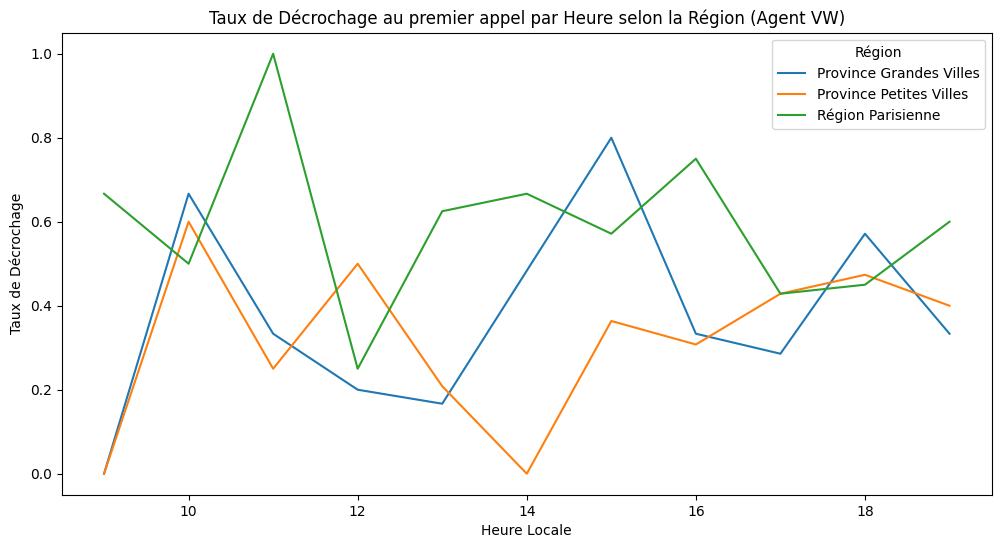

In [79]:
# Calcul du taux de décrochage par heure et par région
decrochage_par_heure = df_vw.drop_duplicates(subset='callto', keep='first').groupby(['local_hour', 'region'])['picked'].mean().reset_index()

# Tracer le taux de décrochage par heure et par région
plt.figure(figsize=(12, 6))
sns.lineplot(data=decrochage_par_heure, x='local_hour', y='picked', hue='region')
plt.title('Taux de Décrochage au premier appel par Heure selon la Région (Agent VW)')
plt.xlabel('Heure Locale')
plt.ylabel('Taux de Décrochage')
plt.legend(title='Région')
plt.show()

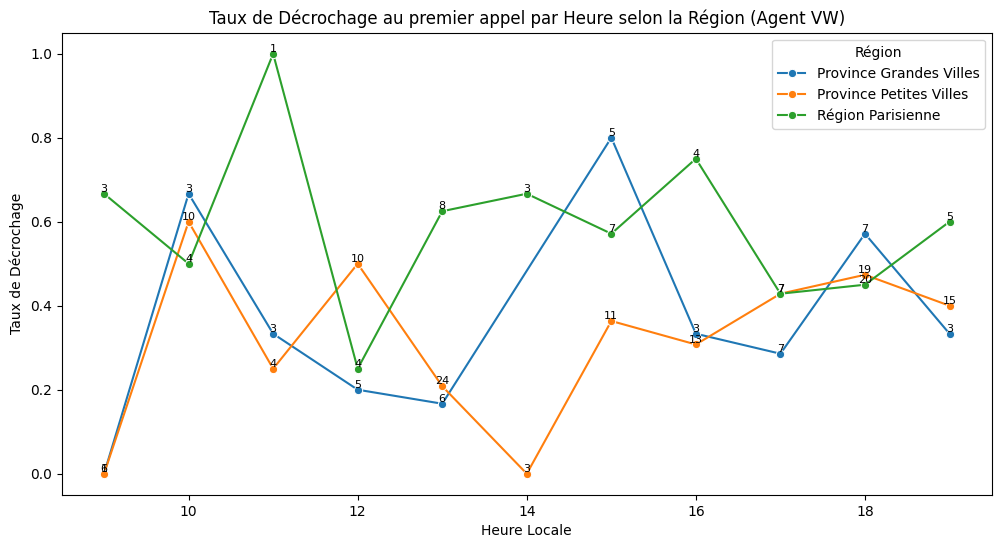

In [84]:
# Calculer le taux de décrochage au premier appel par heure et par région
decrochage_par_heure = df_vw.drop_duplicates(subset='callto', keep='first').groupby(['local_hour', 'region'])['picked'].mean().reset_index()

# Calculer le nombre d'appels par heure et par région
nombre_appels_par_heure = df_vw.drop_duplicates(subset='callto', keep='first').groupby(['local_hour', 'region'])['callto'].count().reset_index()
nombre_appels_par_heure.columns = ['local_hour', 'region', 'nombre_appels']

# Fusionner les deux DataFrames pour avoir les taux et le nombre d'appels
decrochage_par_heure = pd.merge(decrochage_par_heure, nombre_appels_par_heure, on=['local_hour', 'region'])

# Tracer le taux de décrochage par heure et par région
plt.figure(figsize=(12, 6))
sns.lineplot(data=decrochage_par_heure, x='local_hour', y='picked', hue='region', marker='o')
plt.title('Taux de Décrochage au premier appel par Heure selon la Région (Agent VW)')
plt.xlabel('Heure Locale')
plt.ylabel('Taux de Décrochage')
plt.legend(title='Région')

# Ajouter les labels avec le nombre d'appels
for i in range(len(decrochage_par_heure)):
    plt.text(decrochage_par_heure['local_hour'].iloc[i],
             decrochage_par_heure['picked'].iloc[i],
             f"{decrochage_par_heure['nombre_appels'].iloc[i]}",
             horizontalalignment='center',
             verticalalignment='bottom',
             fontsize=8)

plt.show()

In [80]:
# 1. Taux de décrochage au premier appel
# Garder le premier appel pour chaque numéro
premiers_appels = df_vw.drop_duplicates(subset='callto', keep='first')
taux_decrochage_premier_appel = premiers_appels['picked'].mean()

# 2. Taux de décrochage après un échec du premier appel
# Récupérer les numéros où le premier appel a échoué
numeros_echoues = premiers_appels[premiers_appels['picked'] == False]['callto'].unique()

# Filtrer le DataFrame original pour ces numéros
appels_echoues = df_vw[df_vw['callto'].isin(numeros_echoues)]

# Garder le dernier appel pour chaque numéro
derniers_appels = appels_echoues.drop_duplicates(subset='callto', keep='last')

# Calculer le taux de décrochage dans ce sous-ensemble
taux_decrochage_apres_echec = derniers_appels['picked'].mean()

# Afficher les résultats
print(f"Taux de décrochage au premier appel : {taux_decrochage_premier_appel:.2%}")
print(f"Taux de décrochage après échec du premier appel : {taux_decrochage_apres_echec:.2%}")

Taux de décrochage au premier appel : 41.13%
Taux de décrochage après échec du premier appel : 35.29%
